In [1]:
import os
import random
import yaml
import torch
import wandb
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, Resize, Compose, Lambda

os.chdir("../")

from module.vae import VariationalAutoEncoder
from module.data import COCOConditionalDataset

### Download Artifact from Wandb

In [2]:
run = wandb.init()

artifact = run.use_artifact('deepakdhull80/variational-auto-encoder-project/variational-auto-encoder:v111', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: deepakdhull80. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact variational-auto-encoder:v111, 534.27MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:2:13.3


### Initialize Model

In [3]:
state_dict = torch.load(f"artifacts/variational-auto-encoder:v111/model.pt", map_location="cpu")

In [4]:
cfg = yaml.safe_load(open("config/conditional_vae.yaml", "r"))
cfg['data']['data_prefix_path'] = '/Users/deepakdhull/data/coco/2017'

In [5]:
model = VariationalAutoEncoder(cfg)
model.load_state_dict(state_dict)
model = model.eval()

In [21]:
IMG_SIZE = 64
# transform = Compose([Lambda(lambda batch: torch.clamp_(batch * 0.5 + 0.5, min=0, max=1)), Resize((IMG_SIZE, IMG_SIZE), antialias=True), ToPILImage()])
transform = Compose([Lambda(lambda batch: torch.clamp_(batch, min=0, max=1)), Resize((IMG_SIZE, IMG_SIZE), antialias=True), ToPILImage()])

In [22]:
def plot_images(img: list, title: str = "Nothing", figsize=(25,25)):
    print(f"{title} Images")
    _, axs = plt.subplots(1, len(img), figsize=figsize)
    axs = axs.flatten()
    for i, ax in zip(img, axs):
        ax.imshow(i)
        ax.axis('off')
    plt.show()

### Generate Image for random Latent Space

In [27]:
inp = torch.randn(4, 1024)
idx = [0, 1, 0, 1]
conditional = torch.nn.functional.one_hot(torch.tensor(idx), num_classes= cfg['data']['num_classes'])

with torch.no_grad():
    inp, _ = model.reparameterization(inp)
    inp = torch.concat([inp, conditional], dim=1)
    inp_p = model.decoder(inp)
    print(inp_p.shape)

# inp_p = torch.clamp_(inp_p  * 0.5 + 0.5, min=0, max=1)

print(inp_p.min() , inp_p.max())


torch.Size([4, 3, 64, 64])
tensor(0.0601) tensor(0.6289)


In [28]:
imgs = []
for i in range(4):
    imgs.append(np.array(transform(inp_p[i])))

Random Generated Images


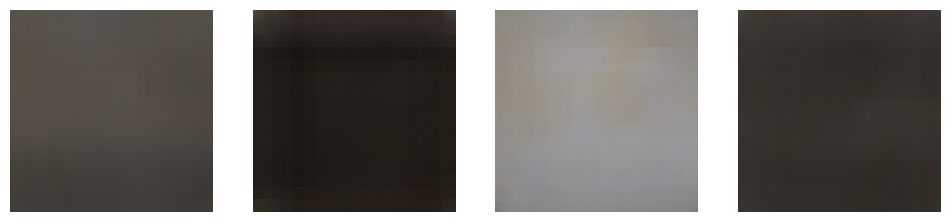

In [29]:
plot_images(imgs, "Random Generated", figsize=(12, 12))

### Generate Back ground images

In [30]:
ds = COCOConditionalDataset(cfg, disable_tansforms=False, train=False)
dl = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)
batch = next(iter(dl))

In [31]:
img, label = batch

In [32]:
with torch.no_grad():
    z = model.encoder(img)
    z = torch.rand_like(z) * 0.5 + z * 0.5
    mu = model.mu_fc(z)
    log_var = model.log_var_fc(z)
    epsilon = torch.rand_like(z)
    sigma = torch.exp(0.5 * log_var)
    z = mu + sigma * epsilon
    z = torch.concat([z, label], dim=1)
    out1 = model.decoder(z)
    out2 = model(img, label)

In [33]:
output1 = out1
output2, kl_loss = out2

In [34]:
gt_imgs, p_imgs, p2_imgs = [], [], []
for i in range(output1.shape[0]):
    gt_imgs.append(np.array(transform(img[i])))
    p_imgs.append(np.array(transform(output1[i])))
    p2_imgs.append(np.array(transform(output2[i])))

Ground Truth Images


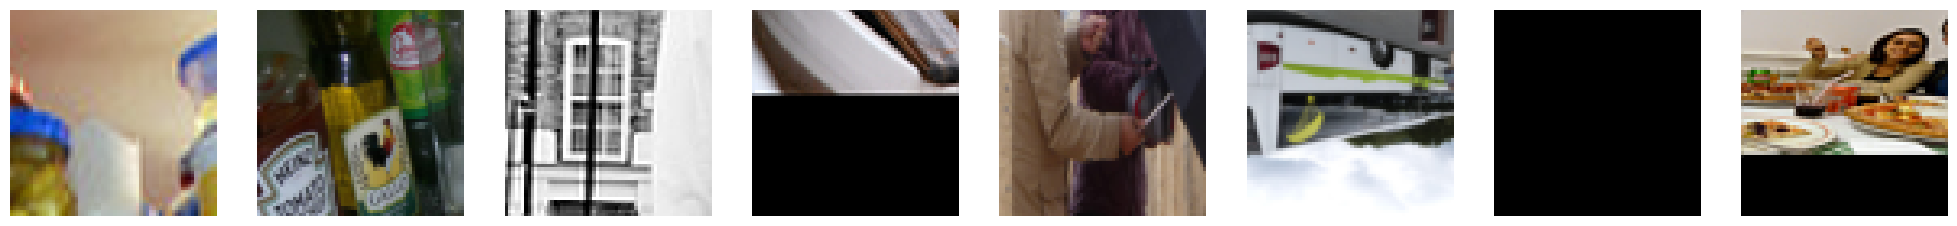

Predicted Images


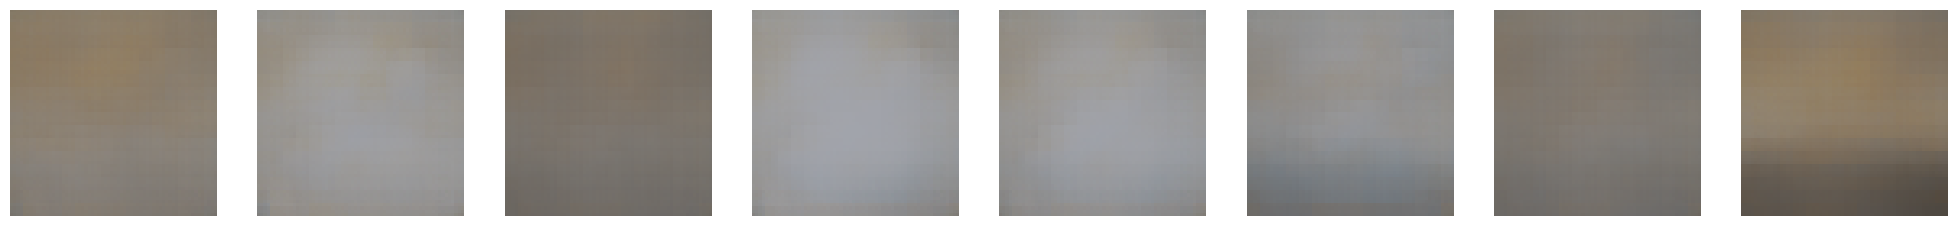

Predicted 2 Images


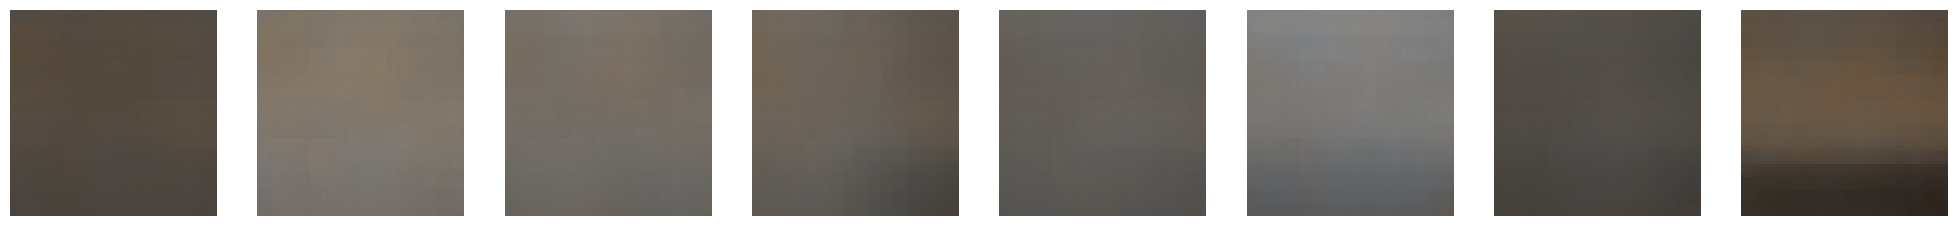

In [35]:
plot_images(gt_imgs, "Ground Truth")
plot_images(p_imgs, "Predicted")
plot_images(p2_imgs, "Predicted 2")